In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_mldata

plt.gray()
%matplotlib inline

In [3]:
mnist = fetch_mldata('MNIST original')
x_data = mnist['data'] / 255.0
del mnist

In [4]:
def next_batch(n):
    return x_data[np.random.randint(0, len(x_data), size=n)]

In [127]:
def q_net(x, reuse=None):
    h = disc_net(x, reuse=reuse)
    with tf.variable_scope('q_net'): 
#         h = tf.layers.dense(x, 128)
        h = tf.nn.relu(h)

        q_p = tf.layers.dense(h, 12) # gaussian priors, 10x categorical vars
    return tf.nn.softmax(q_p[:, :10]), q_p[:, 10:11], tf.nn.softplus(q_p[:, 11:])

def generator(x, c, reuse=None):
    with tf.variable_scope('generator', reuse=reuse):
        h = tf.concat((x, c), axis=1)
        h = tf.layers.dense(h, 7*7*10, activation=tf.nn.relu)
        h = tf.layers.conv2d_transpose(tf.reshape(h, (tf.shape(h)[0], 7, 7, 10)), 64, (3,3), strides=(2,2), padding='same')
        h = tf.nn.relu(h)
        h = tf.layers.conv2d_transpose(h, 1, (3,3), strides=(2,2), padding='same')
    return tf.nn.sigmoid(tf.layers.flatten(h))
def disc_net(x, reuse=None):
    with tf.variable_scope('base_net', reuse=reuse):
        h = tf.layers.dense(x, 128, activation=tf.nn.relu)
    return h
def discriminator(x, reuse=None, reuse_n=None):
    h = disc_net(x, reuse=reuse_n)
    with tf.variable_scope('disc', reuse=reuse):
        h = tf.layers.dense(h, 1, activation=tf.nn.sigmoid)
    return h

def gauss_logli(x, mu, std):
    return tf.reduce_sum(-0.5 * np.log(2*np.pi) - tf.log(std + 1e-8) - 0.5 * (x-mu)**2 / std**2, axis=1)

def log_gauss_other_thing(x):
    return tf.log(tf.reduce_sum(-0.5*x**2, axis=1))

In [128]:
z_dim = 20

In [129]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(1821431)
    Z_in = tf.placeholder(tf.float32, (None, z_dim))
    c_in = tf.placeholder(tf.float32, (None, 11))
    X_in = tf.placeholder(tf.float32, (None, 28 * 28))
    
    g_sample = generator(Z_in, c_in)
    d_fake = discriminator(g_sample)
    d_real = discriminator(X_in, True, True)
    qc_x, mus, sds = q_net(g_sample, True)
    
    d_loss = -tf.reduce_mean(tf.log(d_real + 1e-8) + tf.log(1-d_fake + 1e-8))
    g_loss = -tf.reduce_mean(tf.log(d_fake + 1e-8))
    
    q_ce = -tf.reduce_mean(tf.reduce_sum(tf.log(qc_x+1e-8) * c_in[:, :10], axis=1))
    q_ent = -tf.reduce_mean(tf.reduce_sum(tf.log(c_in[:, :10]+1e-8) * c_in[:, :10], axis=1))

    qgce = -tf.reduce_mean(gauss_logli(c_in[:, 10:], mus, sds))
#     qgp = -tf.reduce_mean(log_gauss_other_thing(c_in))
    
    q_lb = q_ce + q_ent + qgce
    
    
    base_net_vars = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'base_net')
    q_vars = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') \
        + base_net_vars\
        + g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'q_net')
        
    d_step = tf.train.AdamOptimizer(2e-4).minimize(
        d_loss, var_list=g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'disc') + base_net_vars)
    g_step = tf.train.AdamOptimizer(1e-3).minimize(
        g_loss, var_list=g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    q_step = tf.train.AdamOptimizer(2e-4).minimize(q_lb, var_list=q_vars)

In [130]:
try:
    while True:
        tf.get_default_session().close()
except: pass
sess = tf.InteractiveSession(graph=g)
sess.run(tf.global_variables_initializer())

In [131]:
bs = 32

In [132]:
def sample_z(*shape):
    return np.random.uniform(-1, 1.0, shape)
def sample_c(n):
    return np.append(np.random.multinomial(1, [0.1]*10, size=n), np.random.randn(n, 1), axis=1)

In [133]:
dls = []
gls = []
save_every=500
N1 = 4
np.random.seed(1091883)
ref_c = sample_c(N1**2)
ref_z = sample_z(N1**2, z_dim)
for iteration in range(len(dls), 100000):
    if iteration % save_every == 0:
        ims = sess.run(g_sample, feed_dict={Z_in: ref_z, c_in: ref_c}).reshape(-1, 28, 28)
        fig = plt.figure(figsize=(16, 16))
        for i in range(N1*N1):
            ax = fig.add_subplot(N1, N1, i+1)
            ax.imshow(ims[i])
            ax.axis('off')
        fig.savefig('/Users/nikil/Downloads/out/%d.png'%(iteration//save_every))
        plt.close()
    xb = next_batch(bs)
    z_ = sample_z(bs, z_dim)
    c_ = sample_c(bs)
    _, dl = sess.run([d_step, d_loss], feed_dict={X_in: xb, Z_in: z_, c_in: c_})
    _, gl = sess.run([g_step, g_loss], feed_dict={X_in: xb, Z_in: z_, c_in: c_})
    
    sess.run([q_step], feed_dict={X_in: xb, Z_in: z_, c_in: c_})
    dls.append(dl)
    gls.append(gl)
    if iteration % 400 == 0:
        print(f'Iter {iteration}, Discriminator loss: {dl:.5f}, Generator loss: {gl:.5f}')

Iter 0, Discriminator loss: 1.27085, Generator loss: 1.18656
Iter 400, Discriminator loss: 0.95445, Generator loss: 0.87377
Iter 800, Discriminator loss: 1.44932, Generator loss: 0.64235
Iter 1200, Discriminator loss: 0.82820, Generator loss: 1.02516
Iter 1600, Discriminator loss: 1.27932, Generator loss: 0.89977
Iter 2000, Discriminator loss: 1.20871, Generator loss: 0.84312
Iter 2400, Discriminator loss: 0.99875, Generator loss: 0.98578
Iter 2800, Discriminator loss: 1.29860, Generator loss: 0.95045
Iter 3200, Discriminator loss: 1.18997, Generator loss: 0.93330
Iter 3600, Discriminator loss: 0.98559, Generator loss: 1.01093
Iter 4000, Discriminator loss: 0.98079, Generator loss: 1.02150
Iter 4400, Discriminator loss: 1.15311, Generator loss: 1.00308
Iter 4800, Discriminator loss: 1.10522, Generator loss: 0.91915
Iter 5200, Discriminator loss: 1.33708, Generator loss: 0.94087
Iter 5600, Discriminator loss: 1.14605, Generator loss: 0.93679
Iter 6000, Discriminator loss: 1.09822, Gener

KeyboardInterrupt: 

In [134]:
zs = sample_z(11, z_dim)
zs = np.zeros((11, z_dim))
cs = np.zeros((11, 12))
cs[:, 0] = 1
cs[:, -1] = np.linspace(-2, 2, 11)
fig = plt.figure(figsize=(16, 16))
ims = sess.run(g_sample, feed_dict={Z_in: zs, c_in: cs}).reshape(-1, 28, 28)
for i in range(11):
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(ims[i])
    ax.axis('off')

ValueError: Cannot feed value of shape (11, 12) for Tensor 'Placeholder_1:0', which has shape '(?, 11)'

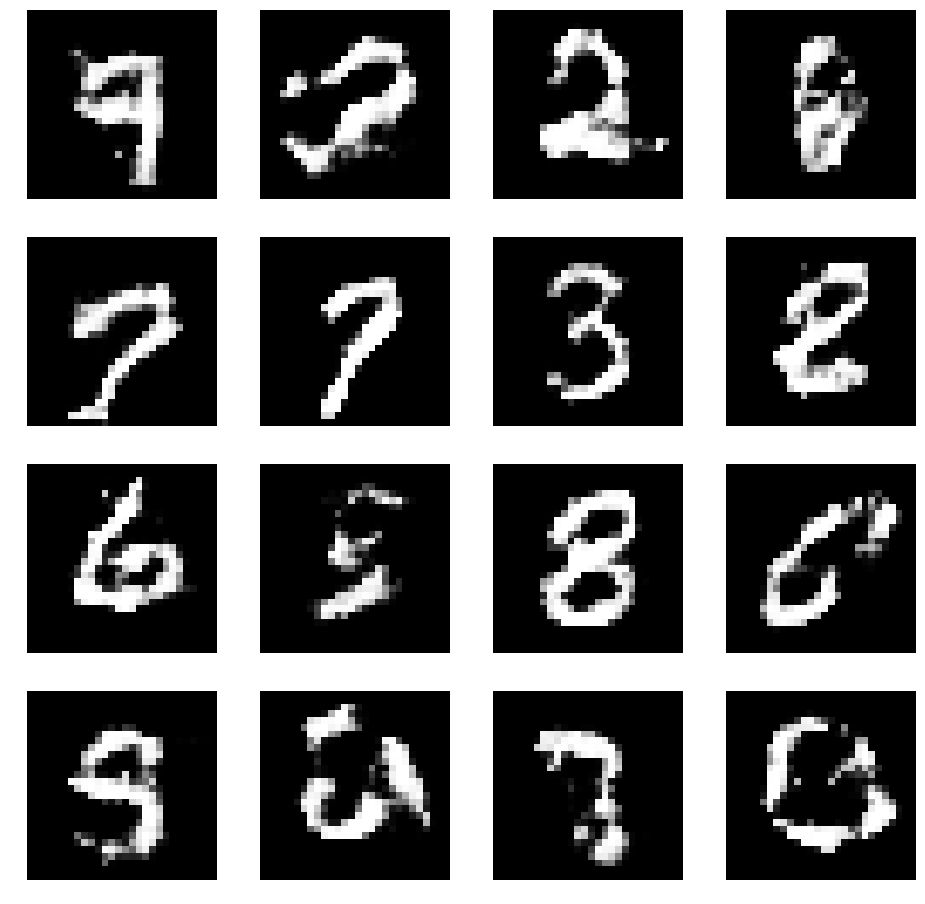

In [135]:
N1 = 4
fig = plt.figure(figsize=(16, 16))
z_ = sample_z(N1**2, z_dim)
c_ = sample_c(N1**2)
ims = sess.run(g_sample, feed_dict={Z_in: z_, c_in: c_}).reshape(-1, 28, 28)
for i in range(N1*N1):
    ax = fig.add_subplot(N1, N1, i+1)
    ax.imshow(ims[i])
    ax.axis('off')